## Linear Quadratic Regulator (LQR)
LQR is a form of optimal control that allows us to stabilize a system while minimizing the "cost" of doing so. A unique feature of LQR is that we can tune the weighting of variables in the cost function, which allows us to prioritize certain variables over others (e.g amount of fuel used vs performance).

Our cost function `J` to be minimized is given by 

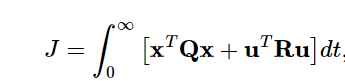


`X` and `U` represent state and control actions, respectively.

We use `Q` and `R` to tune the weighting of `X` and `U`. A larger value of `Q`places a higher weighting on our state, while a larger value of `R` places a higher weighting on our control input. 

If we want the system to stabilize the system as fast as possible without much regard for the energy required to get there, we would choose a large value of `Q` and a small value of `R`.

If we want to stabilize a system using the least amount of actuator effort and we're not concerned with how long it takes, we would choose a large value of `R` and a small value of `Q`.

In [73]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt

In [74]:
dt, t_final = 0.01, 20
pend = sim.Pendulum(
    2.0,  # Large mass, 2.0 kg
    1.0,  # Small mass, 1.0 kg
    2.0,  # length of arm, 2.0 meter
    initial_state=np.array([0.0, 0.0, 0, 0.0]),
)
def force_func(t):
    return 1 * np.exp( -(  ((t-2.0)/0.1)**2) )
    #return 0
simu = sim.Simulation(dt, t_final, force_func)
# simu = sim.Simulation(dt, t_final, lambda t: 0)

In [75]:
Q = 1*np.eye(4)
R = 2*np.eye(1)
lqr_controller = controller.LQR(pend, dt, Q, R)




In [76]:
results = simu.simulate(pend, lqr_controller)

100%|██████████| 2000/2000 [00:25<00:00, 79.91it/s] 


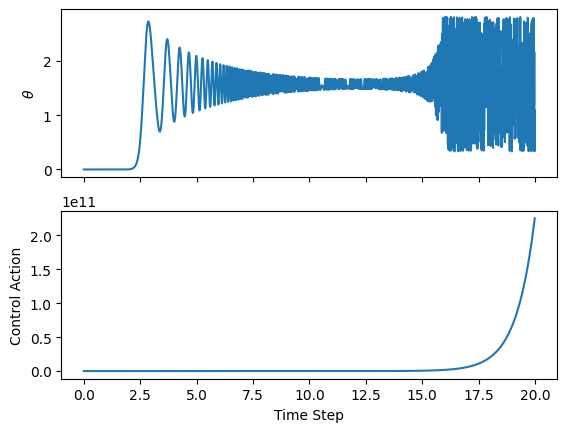

               state                                               \
                   x             xd              t             td   
0.00    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
0.01   4.804022e-179  9.624280e-177  2.402109e-179  4.812532e-177   
0.02   2.745047e-177  5.306564e-175  1.372591e-177  2.653522e-175   
0.03   1.458605e-175  2.813902e-173  7.293390e-176  1.407079e-173   
0.04   7.584642e-174  1.462037e-171  3.792513e-174  7.310854e-172   
...              ...            ...            ...            ...   
19.95   4.826986e+10   5.862852e+10   2.778086e+00  -3.458419e+04   
19.96   4.885972e+10   5.934500e+10   1.185352e+00   2.136152e+05   
19.97   4.945679e+10   6.007023e+10   2.159641e+00  -2.025570e+05   
19.98   5.006116e+10   6.080416e+10   3.361298e-01   1.707243e+03   
19.99   5.067291e+10   6.154721e+10   1.085852e+00   2.100518e+05   

             energy                                  forces  \
            kinetic  potential         

In [77]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(results[("state", "t")], label=r"$\theta$")
ax[0].set_ylabel(r"$\theta$")

ax[1].plot(results[("control action", "control action")], label="Control Action")
ax[1].set_ylabel("Control Action")
ax[1].set_xlabel("Time Step")
plt.show()
print(results)